<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель Факультета Компьютерных Наук НИУ ВШЭ <br> Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 9. Разреженные данные, онлайн-обучение</center>

## <center>Часть 6. Идентификация пользователей по посещенным веб-страницам</center>

<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (session_length и window_size) лучше использовать. Также для выббранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длинны сессии и ширины окна
- Часть 3. Настройка параметров выбранного алгоритма
- Часть 4. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import numpy as np
import pandas as pd
import os
import seaborn as sns
%pylab inline
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

Populating the interactive namespace from numpy and matplotlib


## Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты X_sparse_10users и y_10users, соответствующие обучабщей выборке для 10 пользователей.**

In [2]:
path_to_pickle = '/Users/yorko/Яндекс.Диск/ML/data/capstone_websites_data/'

In [5]:
with open(os.path.join(path_to_pickle, 'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(path_to_pickle, 'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, test_size=0.3, 
                                                     random_state=7, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=7 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV)**

In [45]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите KNeighborsClassifier со 100 ближайшими соседями и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект StratifiedKFold skf) и на выборке (X_valid, y_valid). Не забывайте про распараллеливание (n_jobs).**

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [10]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

In [11]:
%%time
knn_cv_scores = cross_val_score(knn, X_train, y_train, n_jobs=-1, cv=skf)
print(np.mean(knn_cv_scores))

0.552732240902
CPU times: user 99.1 ms, sys: 91.5 ms, total: 191 ms
Wall time: 4.4 s


In [12]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=100, p=2,
           weights='uniform')

In [13]:
%%time
knn_valid_acc = accuracy_score(y_valid, knn.predict(X_valid))

CPU times: user 1.72 s, sys: 27.9 s, total: 29.6 s
Wall time: 32.4 s


In [14]:
knn_valid_acc

0.56767006399620767

**2. Обучите случайный лес (RandomForestClassifier) из 100 деревьев (для воспроизводимости random_state=7). Посмотрите на OOB-оценку (для этого надо сразу установить oob_score=True) и на долю правильных ответов на выборке (X_valid, y_valid). Для распараллеливания задайте n_jobs=-1.**

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
forest = RandomForestClassifier(n_estimators=100, random_state=7, 
                                n_jobs=-1, oob_score=True)

In [17]:
%%time
forest.fit(X_train, y_train)

CPU times: user 28 s, sys: 451 ms, total: 28.5 s
Wall time: 11.7 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=7,
            verbose=0, warm_start=False)

In [18]:
forest.oob_score_

0.72007722007722008

In [19]:
rf_valid_acc = accuracy_score(y_valid, forest.predict(X_valid))

In [20]:
rf_valid_acc

0.71415027257643993

**3. Обучите логистическую регрессию (LogisticRegression) с параметром C по умолчанию и random_state=7 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект skf, созданный ранее) и на выборке (X_valid, y_valid). Для распараллеливания задайте n_jobs=-1.**

In [21]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [22]:
logit = LogisticRegression(n_jobs=-1, random_state=7)

In [23]:
%%time
cv_scores = cross_val_score(logit, X_train, y_train, n_jobs=-1, cv=skf)

CPU times: user 96.6 ms, sys: 43.2 ms, total: 140 ms
Wall time: 1.65 s


In [24]:
np.mean(cv_scores)

0.75248997857025868

In [25]:
%%time
logit.fit(X_train, y_train)

CPU times: user 1.99 s, sys: 51 ms, total: 2.04 s
Wall time: 1.25 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=7, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
accuracy_score(y_valid, logit.predict(X_valid))

0.76416212372600145

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регерссия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации C (быстрее, чем с GridSearchCV).**

**С помощью LogisticRegressionCV подберите параметр C для LogisticRegression сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте linspace из NumPy. Укажите у LogisticRegressionCV параметры multi_class='multinomial' и random_state=7. Для кросс-валидации используйте объект skf, созданный ранее. Для распараллеливания задайте n_jobs=-1.**

**Нарисуйте кривые валидации по параметру С.**

In [27]:
%%time
logit_c_values1 = np.linspace(1e-4, 1e4, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1,
                                            multi_class='multinomial',
                                cv=skf, n_jobs=-1, random_state=7,
                                verbose=True)
logit_grid_searcher1.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.5s finished


CPU times: user 3.13 s, sys: 190 ms, total: 3.32 s
Wall time: 27.3 s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров С.

In [28]:
logit_mean_cv_scores1 = np.mean(logit_grid_searcher1.scores_[31], axis=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [29]:
logit_c_values1[np.argmax(logit_mean_cv_scores1)], np.max(logit_mean_cv_scores1)

(1111.1112000000001, 0.74609152739484907)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

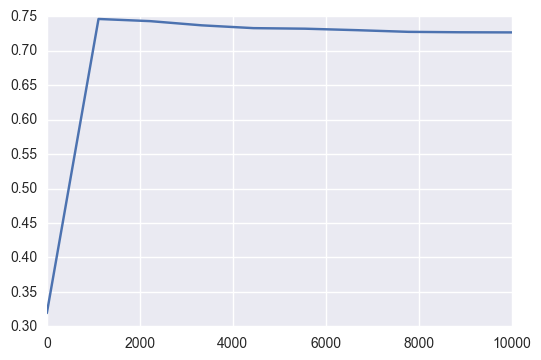

In [30]:
plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра C перебирайте в диапазоне np.linspace(1e-3, 1, 30). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [31]:
%%time
logit_c_values2 = np.linspace(1e-3, 1, 30)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2,
                                            multi_class='multinomial',
                                cv=skf, n_jobs=-1, random_state=7,
                                verbose=True)
logit_grid_searcher2.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


CPU times: user 3.29 s, sys: 394 ms, total: 3.68 s
Wall time: 1min 9s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров С.

In [32]:
logit_mean_cv_scores2 = np.mean(logit_grid_searcher2.scores_[31], axis=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [33]:
logit_c_values2[np.argmax(logit_mean_cv_scores2)], np.max(logit_mean_cv_scores2)

(0.75886206896551722, 0.74934204527793691)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

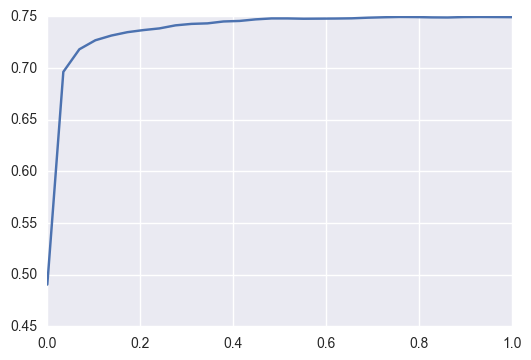

In [34]:
plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке (X_valid, y_valid) для логистической регрессии с лучшим найденным значением C.

In [35]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))

In [36]:
logit_cv_acc

0.7572884569803271

**4. Обучите линейный SVM (LinearSVC) с параметром C=1 и random_state=7 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект skf, созданный ранее) и на выборке (X_valid, y_valid).**

In [37]:
from sklearn.svm import LinearSVC

In [38]:
svm = LinearSVC(C=1, random_state=7)

In [39]:
cv_scores = cross_val_score(svm, X_train, y_train, n_jobs=-1, cv=skf)
np.mean(cv_scores)

0.73786176386070534

In [40]:
svm.fit(X_train, y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=7, tol=0.0001,
     verbose=0)

In [41]:
print(accuracy_score(y_valid, svm.predict(X_valid)))

0.753733112112


**С помощью GridSearchCV подберите параметр C для SVM санчала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте linspace из NumPy. Нарисуйте кривые валидации.**

In [42]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(LinearSVC(random_state=7),
                                svm_params1,
                                cv=skf, n_jobs=-1,
                                verbose=True)
svm_grid_searcher1.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.1min finished


CPU times: user 6.3 s, sys: 171 ms, total: 6.48 s
Wall time: 1min 11s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [43]:
svm_grid_searcher1.best_score_, svm_grid_searcher1.best_params_

(0.66744564112985161, {'C': 5555.5556000000006})

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

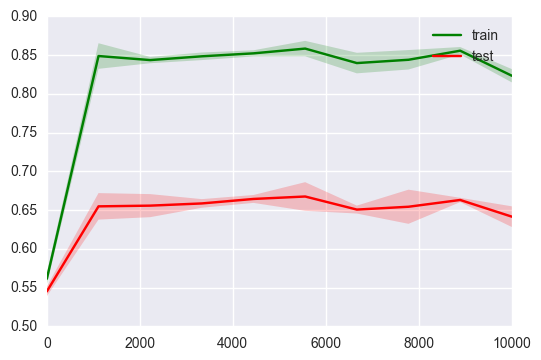

In [46]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений C). Здесь намного осмысленней подбирать C в районе 1., к тому же, так модель быстрее обучается, чем при больших C. **

**С помощью GridSearchCV подберите параметр C для SVM в диапазоне (1e-3, 1), 30 значений, используйте linspace из NumPy. Нарисуйте кривые валидации.**

In [47]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(LinearSVC(random_state=7),
                                svm_params2,
                                cv=skf, n_jobs=-1,
                                verbose=True)
svm_grid_searcher2.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.1min finished


CPU times: user 2.22 s, sys: 440 ms, total: 2.66 s
Wall time: 2min 7s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение С.

In [48]:
svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_

(0.75147327778906725, {'C': 0.10434482758620689})

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

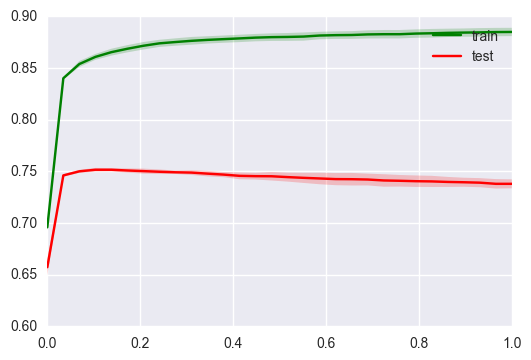

In [49]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке (X_valid, y_valid) для LinearSVC с лучшим найденным значением C.

In [50]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.best_estimator_.predict(X_valid))
svm_cv_acc

0.76534723868215215